### INTRODUCTION

* In this notebook, we will perform image classification. We will make use of transfer learning (e.g. AlexNet, VGG etc.) and compare the results with the version w/o transfer learning, i.e. Transfer learning vs. training from scratch.
* We will also see how to employ data augmentation.
* We have a dataset of animal images (4 classes: BEAR, ELEPHANT, LEOPARD, ZEBRA), one folder for each class.
* The dataset is in MS-Teams/General/Class Materials/datasets folder with name animal-dataset.zip (185 MB).


### LOAD AND PREPROCESS DATA

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
import torch.optim as optim
import torch
import torchvision
from torchvision import models
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from torch import nn
from torchsummary import summary
import torch.utils.data
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


DATA AUGMENTATION

We will apply resizing and normalizing. We may also add data augmentation (especially horizontal flip, blurring and rotation) by activating/deactivating corresponding lines of code.

In [4]:
# define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a specific size
    transforms.RandomHorizontalFlip(p=0.5),  # Flips input with a probability of 50%
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(0, 5)),
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

In [ ]:
#help(transforms.Normalize)
#help(transforms.RandomRotation)
#help(transforms.GaussianBlur)

In [5]:
# get the data from google drive
DATA_DIR = '/content/drive/MyDrive/506_notebooks/datasets/animal_dataset'
dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=transform)


Train and validation split

In [6]:
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for train
val_size = total_size - train_size
print('Total dataset size:', total_size)
print('Training set size:', train_size)
print('Validation set size:', val_size)

Total dataset size: 1400
Training set size: 1120
Validation set size: 280


In [7]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Put dataset into DataLoader.

In [8]:
# Hyperparameters
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [10]:
H = train_features.size()[2]
W = train_features.size()[3]
#d = 3*W*H #Number of input features (pixels)
C = 4 #Number of classes

In [11]:
# TO SHOW LABEL NAMES IN PLOTS
NUM_TO_LABEL=['BEAR','ELEPHANT','LEOPARD', 'ZEBRA']

A QUICK GLANCE

Label: BEAR


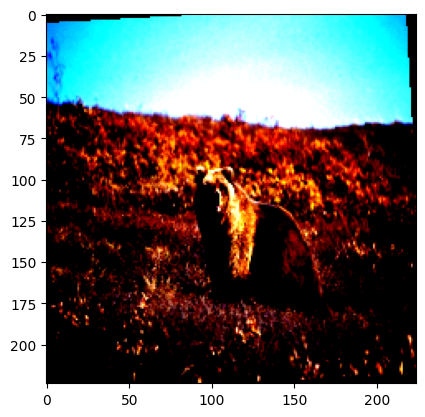

In [17]:
img = train_features[10].squeeze()
label = train_labels[10]
imge = img.permute(1, 2, 0)  #makes the size 224x224x3  instead of 3x224x224
plt.imshow(imge)
print(f"Label: {NUM_TO_LABEL[label]}")

### PLOT FUNCTIONS

PLOT TRAINING LOSS, VALIDATION LOSS AND ACCURACY

In [15]:
def plot(trainingEpoch_loss, validationEpoch_loss, accuracies, epochs):
  figure, axis = plt.subplots(1,2,figsize=(10, 4))
  axis[0].plot(trainingEpoch_loss, label='Training Loss')
  axis[0].plot(validationEpoch_loss,label='Validation Loss')
  axis[0].set_title("Train and Validation Loss")
  axis[1].plot(accuracies, label='Accuracy')
  axis[1].set_title("Validation Accuracy")
  axis[0].legend()
  axis[0].set_ylim(bottom=0)
  axis[1].set_ylim(bottom=0)
  axis[0].set_xlim(left=0)
  axis[1].set_xlim(left=0,right=epochs)
  axis[0].set_xlabel("Epochs")
  axis[1].set_xlabel("Epochs")

  plt.show()

PLOT correct/miss classification comparison images

In [16]:
def plot_miss_correct(image, title):
  plt.imshow(np.transpose(image, (1, 2, 0)))
  plt.title(title)
  plt.axis('off')
  plt.show()

### TRAINING FUNCTION

In [17]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


In [22]:
def train_log_loss_network(model, train_loader, val_loader=None, epochs=20, device="cpu"):
  loss_fn = nn.CrossEntropyLoss() #CrossEntropy is another name for the Logistic Regression loss function. Like before, we phrase learning as minimize a loss function. This is the loss we are going to minimize!

  #We need an optimizer! Adam is a good default one that works "well enough" for most problems
  #To tell Adam what to optimize, we give it the model's parameters - because thats what the learning will adjust
  optimizer = optim.Adam(model.parameters())

  #Devices can be spcified by a string, or a special torch object
  #If it is a string, lets get the correct device
  if device.__class__ == str:
    device = torch.device(device)

  model.to(device)#Place the model on the correct compute resource

  # Create lists to plot loss and accuracy
  trainingEpoch_loss = []
  validationEpoch_loss = []
  accuracies = []
  for epoch in range(epochs):

    model = model.train()#Put our model in training mode
    running_loss = 0.0
    training_step_loss = []
    for inputs, labels in train_loader:

      #Move the batch to the device we are using.
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      y_pred = model(inputs)

      # Compute loss.
      loss = loss_fn(y_pred, labels.long())

      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its parameters
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      training_step_loss.append(running_loss)

    trainingEpoch_loss.append(np.array(training_step_loss).mean())

    if val_loader is None:
      print("Loss after epoch {} is {}".format(epoch, running_loss))
    else:#Lets find out validation performance as we go!
      model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

      # THESE ARE FOR PLOTTING
      total_val_loss=0
      targets = []
      predictions = []
      step_loss = []
      correct_images = []
      correct_labels = []
      correct_predictions = []
      misclassified_images = []
      misclassified_labels = []
      misclassified_predictions = []

      for inputs, labels in val_loader:

        # Move the batch to the device we are using
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model(inputs)

        # Get Validation Loss
        val_loss = loss_fn(y_pred, labels)
        total_val_loss += val_loss.item() * inputs.size(0)
        step_loss.append(total_val_loss)

        # Get correct and incorrect predictions, images and labels
        _, predicted = torch.max(y_pred, 1)
        for i in range(len(predicted)):
          if predicted[i] == labels[i]:
            correct_images.append(inputs[i])
            correct_labels.append(labels[i])
            correct_predictions.append(predicted[i])
          else:
            misclassified_images.append(inputs[i])
            misclassified_labels.append(labels[i])
            misclassified_predictions.append(predicted[i])
        # Get predicted classes
        # y_pred will have a shape (Batch_size, C)
        #We are asking for which class had the largest response along dimension #1, the C dimension
        for pred in torch.argmax(y_pred, dim=1).cpu().numpy():
          predictions.append(pred)
        for l in labels.cpu().numpy():
          targets.append(l)

      validationEpoch_loss.append(np.array(step_loss).mean())
      accuracy = accuracy_score(predictions, targets)
      accuracies.append(accuracy)
      #print("Network Accuracy: ", )
      print("After epoch {}, train loss is {}, validation accuracy is {}".format(epoch+1, running_loss, accuracy))

  ## Visualize correctly classified images
  #print("Correctly classified images:")
  #num_correct_images = 5
  #for i in range(num_correct_images):
  #  plot_miss_correct(correct_images[i].cpu().numpy(), f"True: {NUM_TO_LABEL[correct_labels[i]]}, Predicted: {NUM_TO_LABEL[correct_predictions[i]]}")

  ## Visualize misclassified images
  #print("Misclassified images:")
  #num_misclassified_images = 5
  #for i in range(num_misclassified_images):
  #    plot_miss_correct(misclassified_images[i].cpu().numpy(), f"True: {NUM_TO_LABEL[misclassified_labels[i]]}, Predicted: {NUM_TO_LABEL[misclassified_predictions[i]]}")

  plot(trainingEpoch_loss, validationEpoch_loss, accuracies, epochs)

  return accuracy



### TRAINING A CNN FROM SCRATCH

In [24]:
class GlobalMaxPool2d(nn.Module):
    def forward(self, input):
        return nn.functional.max_pool2d(input, kernel_size=input.size()[2:])

In [23]:
model_fully_conv = nn.Sequential(
  nn.Conv2d(3, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 64, 3, padding=1),
  nn.BatchNorm2d(64),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(64, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  nn.Conv2d(128, 128, 3, padding=1),
  nn.BatchNorm2d(128),
  nn.Dropout2d(p=0.25),
  nn.ReLU(),
  nn.MaxPool2d(2),
  #Now do a convolution with C filters, one for each class, and then perform global-max-pooling
  #Its performance is good, ~90% validation accuracy with 273k parameters.
  nn.Conv2d(128, C, 5), # it does not matter what is current H and W
  GlobalMaxPool2d(), # after global pooling H=1 and W=1
  Flatten()
  ##Below is finishing without GlobalMaxPool.
  ##But, its accuracy is only about 80% and has many more parameters (~13000k due to FC layer).
  #nn.Flatten(),
  #nn.Linear(128 * 14* 14, 512),
  #nn.ReLU(),
  #nn.Linear(512, 4)

)

After epoch 1, train loss is 1510.9030838012695, validation accuracy is 0.5964285714285714
After epoch 2, train loss is 1152.1799640655518, validation accuracy is 0.7107142857142857
After epoch 3, train loss is 1058.3915424346924, validation accuracy is 0.7678571428571429
After epoch 4, train loss is 877.6584672927856, validation accuracy is 0.7964285714285714
After epoch 5, train loss is 829.4085702896118, validation accuracy is 0.8035714285714286
After epoch 6, train loss is 721.2475652694702, validation accuracy is 0.8678571428571429
After epoch 7, train loss is 702.0066566467285, validation accuracy is 0.8857142857142857
After epoch 8, train loss is 688.4829111099243, validation accuracy is 0.8428571428571429
After epoch 9, train loss is 554.5398035049438, validation accuracy is 0.8857142857142857
After epoch 10, train loss is 598.9443473815918, validation accuracy is 0.8678571428571429
After epoch 11, train loss is 564.193347454071, validation accuracy is 0.9035714285714286
After 

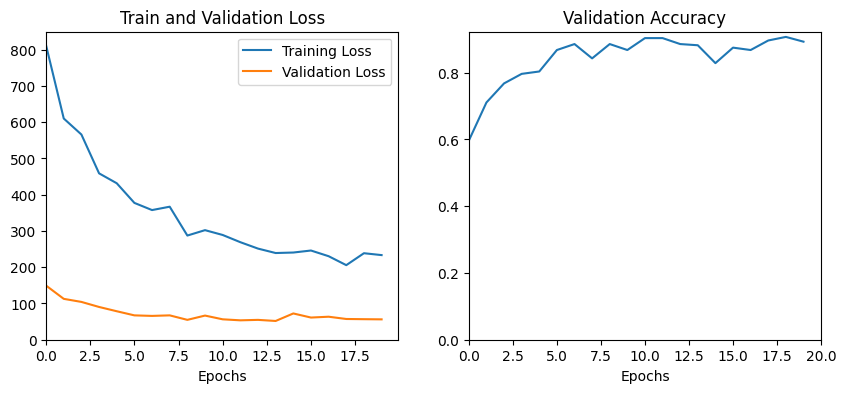

0.8928571428571429

In [25]:
train_log_loss_network(model_fully_conv, train_loader, val_loader=val_loader, epochs=20, device=device)

In [ ]:
summary(model_fully_conv,(3, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         Dropout2d-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          36,928
       BatchNorm2d-7         [-1, 64, 112, 112]             128
         Dropout2d-8         [-1, 64, 112, 112]               0
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        Dropout2d-13          [-1, 128, 56, 56]               0
             ReLU-14          [-1, 128,

### TRANSFER LEARNING (ALEXNET)


Let's first try pretrained AlexNet, which is simpler when compared to VGG16 and ResNet.

In [ ]:
model5 = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 143MB/s]


In [ ]:
# Freeze model weights
for param in model5.parameters():
    param.requires_grad = False

In [ ]:
model5

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
num_features = model5.classifier[6].in_features
print(num_features)

4096


In [ ]:
model5.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, C),
    nn.LogSoftmax(dim=1)
)

Loss after epoch 1 is 222.67101036570966. Validation accuracy: 0.9642857142857143
Loss after epoch 2 is 113.62596858397592. Validation accuracy: 0.9571428571428572
Loss after epoch 3 is 74.30740525084548. Validation accuracy: 0.975
Loss after epoch 4 is 43.62462655134732. Validation accuracy: 0.9642857142857143
Loss after epoch 5 is 48.480134022422135. Validation accuracy: 0.975
Loss after epoch 6 is 38.45244848748189. Validation accuracy: 0.9678571428571429
Loss after epoch 7 is 25.73872404938811. Validation accuracy: 0.9607142857142857
Loss after epoch 8 is 54.107249613338354. Validation accuracy: 0.975
Loss after epoch 9 is 41.949965962179704. Validation accuracy: 0.975
Loss after epoch 10 is 33.40814721887. Validation accuracy: 0.975
Loss after epoch 11 is 49.925678592068834. Validation accuracy: 0.9714285714285714
Loss after epoch 12 is 30.667016936349683. Validation accuracy: 0.9678571428571429
Loss after epoch 13 is 14.031218886520946. Validation accuracy: 0.9785714285714285
Los

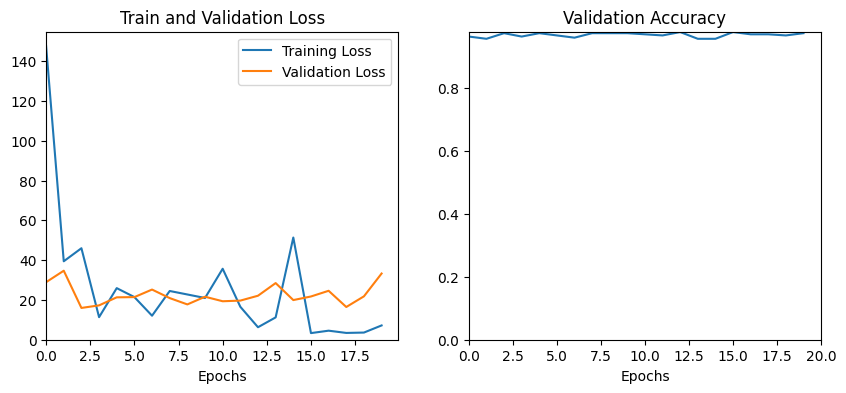

0.975

In [ ]:
train_log_loss_network(model5, train_loader, val_loader, epochs=20, device=device)

In [ ]:
# summary works after the model is trained
summary(model5,(3, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

### TRANSFER LEARNING (VGG)

Let's also try VGG16 (pretrained on ImageNet) which is a deeper and more powerful model.

In [ ]:
model3 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model3

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freeze model weights
for param in model3.parameters():
    param.requires_grad = False

In [ ]:
# This will give you the number of features given to the classifier's Xth layer.
num_features = model3.classifier[6].in_features
print(num_features)

4096


In [ ]:
# Now we would like to replace the 6th layer of the classifier part of VGG.
model3.classifier[6] = nn.Sequential(
                        nn.Linear(num_features, 256),
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(256, C),
                        nn.LogSoftmax(dim=1))
#model3

Loss after epoch 1 is 90.57662697828346. Validation accuracy: 0.9964285714285714
Loss after epoch 2 is 14.106410244414292. Validation accuracy: 1.0
Loss after epoch 3 is 6.312703606454306. Validation accuracy: 0.9964285714285714
Loss after epoch 4 is 31.727004916378064. Validation accuracy: 0.9964285714285714
Loss after epoch 5 is 16.766118869707498. Validation accuracy: 1.0
Loss after epoch 6 is 7.8504230119797285. Validation accuracy: 0.9964285714285714
Loss after epoch 7 is 4.6504255339868905. Validation accuracy: 0.9928571428571429
Loss after epoch 8 is 6.983954061176291. Validation accuracy: 0.9964285714285714
Loss after epoch 9 is 12.307540167063053. Validation accuracy: 0.9964285714285714
Loss after epoch 10 is 5.385997495071024. Validation accuracy: 0.9964285714285714
Loss after epoch 11 is 11.662439055409038. Validation accuracy: 0.9928571428571429
Loss after epoch 12 is 6.243429052057415. Validation accuracy: 0.9964285714285714
Loss after epoch 13 is 18.20765885852404. Valida

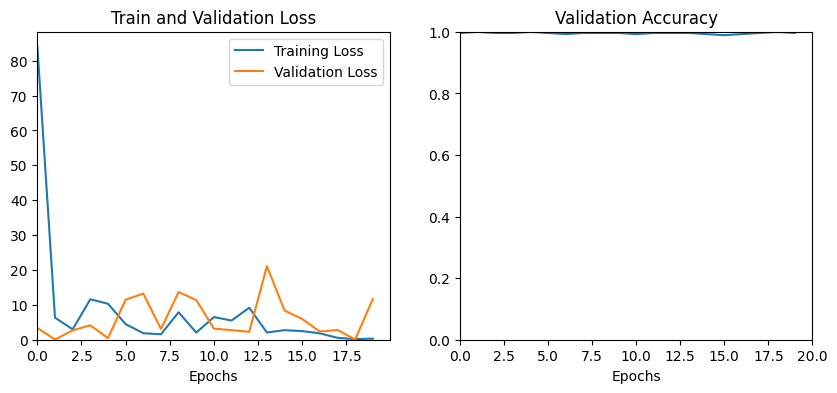

0.9964285714285714

In [ ]:
train_log_loss_network(model3, train_loader, val_loader, epochs=20, device=device)

In [ ]:
# summary works after the model is trained
summary(model3,(3, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Architecture comparison:

- Model trained from scratch has 273k parameters, whereas pretrained models has 61m (AlexNet) and 135m (VGG16) parameters in total.
- Since most of the pretrained model's parameters are frozen, a small portion of them are optimized about 5m for AlexNet and about 1m for VGG16.


### Performance comparison:

- Model trained from scratch reached about 85% accuracy after 20 epochs.
- Pretrained models easily reached above 98%. Especially very powerful VGG16 has seen 100% after 2nd epoch.


Another PyTorch VGG16 transfer learning example can be found at:
https://www.kaggle.com/code/gabrielloye/pytorch-vgg16-natural-images